In [152]:
from pyspark.sql import SparkSession

# Initialize spark session
spark = SparkSession.builder.appName("Big Data - Customer Purchases Analysis").getOrCreate()

# Load the dataset customer purchse
df1 = spark.read.csv("/content/uwl/customer_purchases.csv", header=True, inferSchema=True)

# Explanation of structure
df1.printSchema()
df1.show(5)
df1.describe().show()
print("Total number of rows: ", df1.count());
print("Total number of columns: ", len(df1.columns));


root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- AnnualIncome: integer (nullable = true)
 |-- SpendingScore: integer (nullable = true)
 |-- PurchaseCategory: string (nullable = true)
 |-- TotalPurchases: integer (nullable = true)
 |-- PurchaseAmount: double (nullable = true)

+----------+---+------+------------+-------------+----------------+--------------+--------------+
|CustomerID|Age|Gender|AnnualIncome|SpendingScore|PurchaseCategory|TotalPurchases|PurchaseAmount|
+----------+---+------+------------+-------------+----------------+--------------+--------------+
|         1| 49|Female|       22551|           94|          Sports|            20|        387.87|
|         2| 34|Female|       89715|           80|         Fashion|             1|        236.01|
|         3| 39|Female|       42910|           85|         Fashion|             8|         50.24|
|         4| 35|Female|       71190|           47|     El

In [153]:
from pyspark.sql.functions import col, when

# Replace 0 with null colums SpendingScore and TotalPurchase
df1 = df1.withColumn("SpendingScore", when(col("SpendingScore") == 0, None).otherwise(col("SpendingScore")))
df1 = df1.withColumn("TotalPurchases", when(col("TotalPurchases") == 0, None).otherwise(col("TotalPurchases")))

# The medians
median_values = df1.approxQuantile(["SpendingScore", "TotalPurchases"], [0.5], 0.01)

# Extract actual float values from list
median_spend = median_values[0][0]
median_total = median_values[1][0]

# Fill nulls with medians
df2 = df1.fillna({"SpendingScore": median_spend, "TotalPurchases": median_total})
df2.show(5)

+----------+---+------+------------+-------------+----------------+--------------+--------------+
|CustomerID|Age|Gender|AnnualIncome|SpendingScore|PurchaseCategory|TotalPurchases|PurchaseAmount|
+----------+---+------+------------+-------------+----------------+--------------+--------------+
|         1| 49|Female|       22551|           94|          Sports|            20|        387.87|
|         2| 34|Female|       89715|           80|         Fashion|             1|        236.01|
|         3| 39|Female|       42910|           85|         Fashion|             8|         50.24|
|         4| 35|Female|       71190|           47|     Electronics|             3|         40.42|
|         5| 35|  Male|       28451|           84|         Fashion|            16|        110.01|
+----------+---+------+------------+-------------+----------------+--------------+--------------+
only showing top 5 rows



In [154]:
#create 3rd DataFrame
df3 = df2.filter((col("Age") != 0) & (col("AnnualIncome") != 0) & (col("PurchaseAmount") != 0))
df3.show(5)

+----------+---+------+------------+-------------+----------------+--------------+--------------+
|CustomerID|Age|Gender|AnnualIncome|SpendingScore|PurchaseCategory|TotalPurchases|PurchaseAmount|
+----------+---+------+------------+-------------+----------------+--------------+--------------+
|         1| 49|Female|       22551|           94|          Sports|            20|        387.87|
|         2| 34|Female|       89715|           80|         Fashion|             1|        236.01|
|         3| 39|Female|       42910|           85|         Fashion|             8|         50.24|
|         4| 35|Female|       71190|           47|     Electronics|             3|         40.42|
|         5| 35|  Male|       28451|           84|         Fashion|            16|        110.01|
+----------+---+------+------------+-------------+----------------+--------------+--------------+
only showing top 5 rows



In [155]:
from pyspark.sql.functions import col, mean, stddev, variance, min, max, count, when

# Filter rows where any of the key columns are 0
df3 = df2.filter((col("Age") != 0) & (col("AnnualIncome") != 0) & (col("PurchaseAmount") != 0))

# Number of rows removed
rows_removed = df2.count() - df3.count()
print("Total number of rows removed:", rows_removed)



Total number of rows removed: 0


In [156]:
from pyspark.sql.functions import rand, round
from pyspark.sql.functions import min, max, mean, stddev, variance

# Add a synthetic 'BloodPressure' column to df3
# Normal range for systolic BP is around 90–140; here we simulate between 90 and 150
df3 = df3.withColumn("BloodPressure", round(rand() * 60 + 90))  # values from 90 to 150

# Compute summary statistics
bp_stats = df3.select(
    min("BloodPressure").alias("Min"),
    max("BloodPressure").alias("Max"),
    mean("BloodPressure").alias("Mean"),
    variance("BloodPressure").alias("Variance"),
    stddev("BloodPressure").alias("StdDev")
)
bp_stats.show()

# Compute median
median_bp = df3.approxQuantile("BloodPressure", [0.5], 0.01)[0]
print("Median BloodPressure:", median_bp)

+----+-----+------+----------------+------------------+
| Min|  Max|  Mean|        Variance|            StdDev|
+----+-----+------+----------------+------------------+
|90.0|150.0|119.61|314.081981981982|17.722358251146545|
+----+-----+------+----------------+------------------+

Median BloodPressure: 120.0


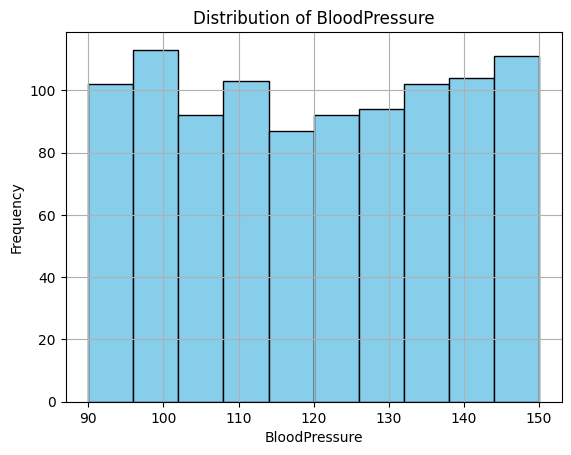

In [157]:
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
bp_pd = df3.select("BloodPressure").toPandas()

# Plot histogram
plt.hist(bp_pd["BloodPressure"], bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of BloodPressure")
plt.xlabel("BloodPressure")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

+-----------+
|  quartiles|
+-----------+
|[6, 10, 16]|
+-----------+



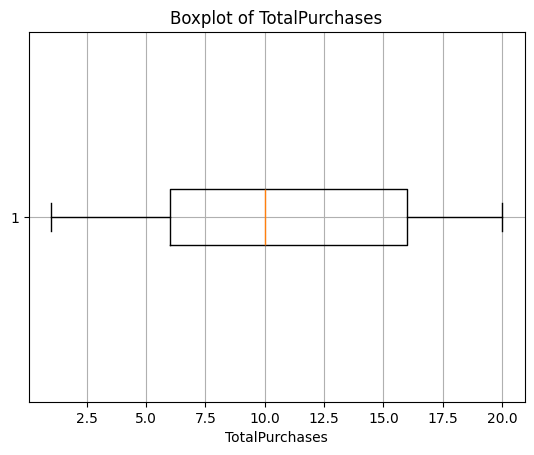

In [158]:
# Quartile info of the ‘Total purchase’ feature
df3.selectExpr([ "percentile_approx(TotalPurchases, array(0.25, 0.5, 0.75)) as quartiles"]).show()

import matplotlib.pyplot as plt
# Convert to pandas for plotting
tp_pd = df3.select("TotalPurchases").toPandas()
# Boxplot
plt.boxplot(tp_pd["TotalPurchases"].dropna(), vert=False)
plt.title("Boxplot of TotalPurchases")
plt.xlabel("TotalPurchases")
plt.grid(True)
plt.show()

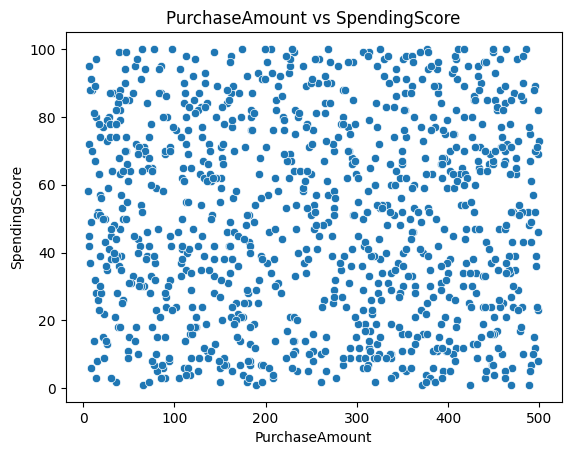

Pearson correlation: -0.003744425146733317


In [159]:
import seaborn as sns
# Scatterplot
df3_pd = df3.select("PurchaseAmount", "SpendingScore").dropna().toPandas()
sns.scatterplot(data=df3_pd, x="PurchaseAmount", y="SpendingScore")
plt.title("PurchaseAmount vs SpendingScore")
plt.show()

# Correlation
correlation = df3.stat.corr("PurchaseAmount", "SpendingScore")
print(f"Pearson correlation: {correlation}")

In [160]:
# SQL view named "customers" from the DataFrame df3
df3.createOrReplaceTempView("customers")

# filtering to include only records where Age is less than 50 and SpendingScore is greater than 100.
spark.sql("""
    SELECT Age, SpendingScore
    FROM customers
    WHERE Age < 50 AND SpendingScore > 100
""").show()

+---+-------------+
|Age|SpendingScore|
+---+-------------+
+---+-------------+



In [161]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

# Add Outcome column
spending_median = df3.approxQuantile("Age", [0.5], 0.0)[0]
purchase_median = df3.approxQuantile("TotalPurchases", [0.5], 0.0)[0]
df3 = df3.withColumn("Outcome", when((col("age") > spending_median) & (col("TotalPurchases") > purchase_median), 1).otherwise(0))

# Cast label column to DoubleType
df3 = df3.withColumn("label", col("Outcome").cast(DoubleType()))

# Assemble feature vector (even for a single feature)
assembler = VectorAssembler(inputCols=["PurchaseAmount"], outputCol="features")
df3 = assembler.transform(df3)

# Select features and label
final_data = df3.select("features", "label")

# Train-test split
train, test = final_data.randomSplit([0.7, 0.3], seed=42)

# Build and train Decision Tree classifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5)
model_dt = dt.fit(train)

# Predict on test set
predictions = model_dt.transform(test)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Decision Tree Accuracy: {accuracy:.4f}")
print("Model Summary:\n", model_dt.toDebugString)


Decision Tree Accuracy: 0.7461
Model Summary:
 DecisionTreeClassificationModel: uid=DecisionTreeClassifier_b9554ed4d6ac, depth=0, numNodes=1, numClasses=2, numFeatures=1
  Predict: 0.0



In [162]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType


df3.show(5)
print(df3.columns)

# Select features and label
final_data = df3.select("features", "label")

# Split data into train/test
train, test = final_data.randomSplit([0.7, 0.3], seed=42)

# Initialize logistic regression for multiclass
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20, family="multinomial")

# Train model
model = lr.fit(train)

# Predict
predictions = model.transform(test)

# Evaluate accuracy with MulticlassClassificationEvaluator
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

print(f"Logistic Regression Accuracy: {accuracy:.4f}")

# Show prediction samples
predictions.select("label", "prediction", "probability").show(5)


+----------+---+------+------------+-------------+----------------+--------------+--------------+-------------+-------+-----+--------+
|CustomerID|Age|Gender|AnnualIncome|SpendingScore|PurchaseCategory|TotalPurchases|PurchaseAmount|BloodPressure|Outcome|label|features|
+----------+---+------+------------+-------------+----------------+--------------+--------------+-------------+-------+-----+--------+
|         1| 49|Female|       22551|           94|          Sports|            20|        387.87|        109.0|      1|  1.0|[387.87]|
|         2| 34|Female|       89715|           80|         Fashion|             1|        236.01|         92.0|      0|  0.0|[236.01]|
|         3| 39|Female|       42910|           85|         Fashion|             8|         50.24|        111.0|      0|  0.0| [50.24]|
|         4| 35|Female|       71190|           47|     Electronics|             3|         40.42|         97.0|      0|  0.0| [40.42]|
|         5| 35|  Male|       28451|           84|     

In [163]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Display some sample data and check columns
df3.show(5)
print(df3.columns)

# Drop 'features' column if it exists already
if "features" in df3.columns:
    df3 = df3.drop("features")

# 'AnnualIncome' as predictor
assembler = VectorAssembler(inputCols=["AnnualIncome"], outputCol="features")
df3 = assembler.transform(df3)

# features and label column ('PurchaseAmount')
final_data = df3.select("features", "PurchaseAmount")

# Split data into training and test sets (70% train, 30% test)
train, test = final_data.randomSplit([0.7, 0.3], seed=42)

# Initialize Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="PurchaseAmount")

# Train the model
model = lr.fit(train)

# Predict on test data
predictions = model.transform(test)

# Evaluate the model performance using RMSE and R-squared
evaluator_rmse = RegressionEvaluator(labelCol="PurchaseAmount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="PurchaseAmount", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

# Print results
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Show some predictions vs actuals
predictions.select("PurchaseAmount", "prediction").show(5)

# Model summary for deeper insights
training_summary = model.summary
print(f"Number of iterations: {training_summary.totalIterations}")
print(f"Objective history: {training_summary.objectiveHistory}")
print(f"Coefficients: {model.coefficients}")
print(f"Intercept: {model.intercept}")
print(f"Training RMSE: {training_summary.rootMeanSquaredError:.4f}")
print(f"Training R2: {training_summary.r2:.4f}")


+----------+---+------+------------+-------------+----------------+--------------+--------------+-------------+-------+-----+--------+
|CustomerID|Age|Gender|AnnualIncome|SpendingScore|PurchaseCategory|TotalPurchases|PurchaseAmount|BloodPressure|Outcome|label|features|
+----------+---+------+------------+-------------+----------------+--------------+--------------+-------------+-------+-----+--------+
|         1| 49|Female|       22551|           94|          Sports|            20|        387.87|        109.0|      1|  1.0|[387.87]|
|         2| 34|Female|       89715|           80|         Fashion|             1|        236.01|         92.0|      0|  0.0|[236.01]|
|         3| 39|Female|       42910|           85|         Fashion|             8|         50.24|        111.0|      0|  0.0| [50.24]|
|         4| 35|Female|       71190|           47|     Electronics|             3|         40.42|         97.0|      0|  0.0| [40.42]|
|         5| 35|  Male|       28451|           84|     